In [13]:
import pandas as pd

In [14]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import Row
from pyspark.sql.types import IntegerType
# create SparkSession
spark = SparkSession.builder.master("local[*]") \
                	.appName('SparkSNCF') \
                	.getOrCreate()

# extract SparkContext
sc = spark.sparkContext

print('Spark is ready with CPU usage :', sc.defaultParallelism)

Spark is ready with CPU usage : 4


# 1- Analyse exploratoire dataset Citi bike trip 

## a-Nombre de nouvelle utilisation par heure de la journée

In [15]:
rddWordCount = spark.read.option("delimiter", ",").option("header",True).csv('2013-07 - Citi Bike trip data.csv')

In [16]:
rddWordCount.show(2)

+------------+-------------------+-------------------+----------------+------------------+----------------------+-----------------------+--------------+----------------+--------------------+---------------------+------+--------+----------+------+
|tripduration|          starttime|           stoptime|start station id|start station name|start station latitude|start station longitude|end station id|end station name|end station latitude|end station longitude|bikeid|usertype|birth year|gender|
+------------+-------------------+-------------------+----------------+------------------+----------------------+-----------------------+--------------+----------------+--------------------+---------------------+------+--------+----------+------+
|         634|2013-07-01 00:00:00|2013-07-01 00:10:34|             164|   E 47 St & 2 Ave|           40.75323098|           -73.97032517|           504| 1 Ave & E 15 St|         40.73221853|         -73.98165557| 16950|Customer|        \N|     0|
|        154

In [70]:
rddWordCount.createOrReplaceTempView("New_use_HourDay")

In [82]:
groupDF = spark.sql("SELECT substring(starttime,12,2) as hour , count(*) AS Count_newuser from New_use_HourDay group by substring(starttime,12,2)")

In [83]:
from pyspark.sql.functions import date_format
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.types import TimestampType

In [84]:
groupDF1=groupDF.withColumn("hour", date_format(unix_timestamp("hour", 'HH').cast(TimestampType()), "HH"))

In [94]:
groupDf1 = groupDf1.sort(col("hour").asc())

In [95]:
groupDf1.show(truncate=False)

+---------+-------------+----+
|HourofDay|Count_newuser|hour|
+---------+-------------+----+
|00       |10631        |00  |
|01       |6011         |01  |
|02       |3748         |02  |
|03       |2313         |03  |
|04       |1727         |04  |
|05       |3496         |05  |
|06       |14464        |06  |
|07       |31315        |07  |
|08       |56878        |08  |
|09       |47178        |09  |
|10       |32933        |10  |
|11       |36211        |11  |
|12       |44935        |12  |
|13       |47203        |13  |
|14       |46008        |14  |
|15       |49195        |15  |
|16       |58982        |16  |
|17       |81124        |17  |
|18       |79931        |18  |
|19       |63648        |19  |
+---------+-------------+----+
only showing top 20 rows



In [81]:
groupDf1.createOrReplaceTempView("View_data1")

In [77]:
groupDf1.coalesce(1).write.format('com.databricks.spark.csv').options(header='true').save('newusersbike')

AnalysisException: path file:/Users/mamadounabycamara/Documents/FINAL/newusersbike already exists.

##file:/Users/mamadounabycamara/Documents/FINAL/

## b- Nombre de trajet de durée supérieur à une heure

In [25]:
groupDf2 = spark.sql("SELECT count(*) as nbretjtsuphour from New_use_HourDay where INT(tripduration)>3600")

In [26]:
groupDf2.show(truncate=False)

+--------------+
|nbretjtsuphour|
+--------------+
|11685         |
+--------------+



In [ ]:
groupDf2.coalesce(1).write.format('com.databricks.spark.csv').options(header='true').save('nbre_de_trjt')

## c- Durée moyenne par type d'utilisateur

In [27]:
DF3 = spark.sql("SELECT usertype, AVG(INT(tripduration)) as usertemps from New_use_HourDay group by usertype")

In [28]:
DF3.createOrReplaceTempView("vue_usertemps")


##.withColumn("usertemps", date_format(unix_timestamp("usertemps", 'ss').cast(TimestampType()), "HH:mm:ss"))

In [29]:
DF5 = spark.sql("SELECT usertype, usertemps,INT(INT(usertemps)/60) as minute from vue_usertemps")

In [30]:
DF5.createOrReplaceTempView("vue_usertemps1")

In [31]:
DF6 = spark.sql("SELECT usertype, usertemps, '00' as heure, minute, INT(((INT(usertemps)/60)-minute)*60) as seconde  from vue_usertemps1")

In [32]:
DF6.createOrReplaceTempView("vue_usertemps2")

##DF7 = spark.sql("SELECT usertype, usertemps, concat(col(minute),lit(':'),col(seconde)) as duree_moyen from vue_usertemps2")

##DF6.show(truncate=False)

In [33]:
from pyspark.sql.functions import concat, col, lit

In [35]:
DF6.withColumn("dureemoy",concat(col("heure"),lit(' h '),
    col("minute"),lit(' mn '),col("seconde"),lit('s'))).show()

+----------+------------------+-----+------+-------+--------------+
|  usertype|         usertemps|heure|minute|seconde|      dureemoy|
+----------+------------------+-----+------+-------+--------------+
|Subscriber| 859.2733982447296|   00|    14|     18|00 h 14 mn 18s|
|  Customer|1528.6795129062687|   00|    25|     27|00 h 25 mn 27s|
+----------+------------------+-----+------+-------+--------------+



In [ ]:
DF6.coalesce(1).write.format('com.databricks.spark.csv').options(header='true').save('temps_moyen_usertype')

## d-Fréquence des personnes qui utilisent les vélos ( )

In [36]:
groupDF4 = spark.sql("SELECT gender, count(*) as freqgenre from New_use_HourDay group by gender")

In [37]:
groupDF4.createOrReplaceTempView("vue_personf")

In [38]:
 g = spark.sql("SELECT sum(freqgenre) as som_l from vue_personf")

In [39]:
g.createOrReplaceTempView("vue_g")

In [40]:
groupDF5 = spark.sql("SELECT gender,freqgenre, float((100*freqgenre/INT(som_l))) as pourcentage from vue_personf,vue_g where 1=1")

In [41]:
from pyspark.sql.functions import col, when

In [42]:
freqperso = groupDF5.select(col("*"), when(col("gender") == "0", ("female")) \
.when(col("gender") == "1", ("male")) \
.when(col("gender") == "2", ("inconnu"))\
.alias("label")).show()

+------+---------+-----------+-------+
|gender|freqgenre|pourcentage|  label|
+------+---------+-----------+-------+
|     0|   174931|  20.740774| female|
|     1|   511479|  60.643738|   male|
|     2|   157006|  18.615488|inconnu|
+------+---------+-----------+-------+



In [43]:
freqperso.coalesce(1).write.format('com.databricks.spark.csv').options(header='true').save('frequence_genre_biker')

AttributeError: 'NoneType' object has no attribute 'coalesce'

## e-les gares les plus visités selon startime et endtime

In [ ]:
##   starttime|           stoptime|start station id|start station name|start station latitude|start station longitude|end station id|end station name|end station latitude|end station longitude|bikeid|usertype|birth year|gender|

In [189]:
spark.sql("SELECT `start station id`, count(*)as nb from New_use_HourDay group by `start station id`").show()

+----------------+----+
|start station id|  nb|
+----------------+----+
|             467|1771|
|             296|1886|
|             447|3592|
|             307|2544|
|             475|3456|
|             334|3548|
|             470|3176|
|             462|3905|
|             442|4095|
|             448|3366|
|             383|2500|
|             282| 619|
|             232|1148|
|             483|3199|
|             317|2859|
|             388|3914|
|             521|7048|
|             428|2789|
|             495|2745|
|            2012| 714|
+----------------+----+
only showing top 20 rows



In [185]:
garesvisitstart = spark.sql("""SELECT `start station id`, `start station name`,count(tripduration) as nb_visiteur_start from New_use_HourDay group by `start station id`, `start station name`""")

In [192]:
garesvisitstart = garesvisitstart.sort(col("start station name").asc())

In [193]:
garesvisitstart.show()

+----------------+--------------------+-----------------+
|start station id|  start station name|nb_visiteur_start|
+----------------+--------------------+-----------------+
|             504|     1 Ave & E 15 St|             4138|
|            2003|     1 Ave & E 18 St|             2571|
|             536|     1 Ave & E 30 St|             2906|
|             455|     1 Ave & E 44 St|             2229|
|             489|    10 Ave & W 28 St|             2874|
|             458|    11 Ave & W 27 St|             2677|
|             478|    11 Ave & W 41 St|             2850|
|             514|    12 Ave & W 40 St|             3311|
|             528|     2 Ave & E 31 St|             4331|
|             290|     2 Ave & E 58 St|             3896|
|             298|3 Ave & Schermerh...|              392|
|             474|     5 Ave & E 29 St|             3086|
|            2004|   6 Ave & Broome St|             1920|
|             377|    6 Ave & Canal St|             2510|
|             

In [194]:
garesvisitstart.createOrReplaceTempView("start_visit")

In [196]:
garesvisitend = spark.sql("""SELECT `end station id`, `end station name`,count(tripduration) as nb_visiteur_end from New_use_HourDay group by `end station id`, `end station name`""")

In [197]:
garesvisitend = garesvisitend.sort(col("end station name").asc())

In [198]:
garesvisitend.show()

+--------------+--------------------+---------------+
|end station id|    end station name|nb_visiteur_end|
+--------------+--------------------+---------------+
|           504|     1 Ave & E 15 St|           4241|
|          2003|     1 Ave & E 18 St|           2531|
|           536|     1 Ave & E 30 St|           2950|
|           455|     1 Ave & E 44 St|           2277|
|           489|    10 Ave & W 28 St|           2857|
|           458|    11 Ave & W 27 St|           2650|
|           478|    11 Ave & W 41 St|           3069|
|           514|    12 Ave & W 40 St|           3655|
|           528|     2 Ave & E 31 St|           4358|
|           290|     2 Ave & E 58 St|           3862|
|           298|3 Ave & Schermerh...|            472|
|           474|     5 Ave & E 29 St|           3039|
|          2004|   6 Ave & Broome St|           1949|
|           377|    6 Ave & Canal St|           2596|
|           505|     6 Ave & W 33 St|           2777|
|          2001| 7 Ave & Far

In [202]:
garesvisitend.createOrReplaceTempView("end_visit")

In [204]:
garesvisitall= spark.sql("""SELECT `end station name`,`nb_visiteur_start`,`nb_visiteur_end` from end_visit,start_visit where 1=1""")

In [205]:
garesvisitall.show()

+----------------+-----------------+---------------+
|end station name|nb_visiteur_start|nb_visiteur_end|
+----------------+-----------------+---------------+
|11 Ave & W 27 St|             3139|           2650|
|11 Ave & W 27 St|             2677|           2650|
|11 Ave & W 27 St|             2814|           2650|
|11 Ave & W 27 St|              295|           2650|
|11 Ave & W 27 St|             2510|           2650|
|11 Ave & W 27 St|             1742|           2650|
|11 Ave & W 27 St|             2343|           2650|
|11 Ave & W 27 St|             3983|           2650|
|11 Ave & W 27 St|             7387|           2650|
|11 Ave & W 27 St|             6162|           2650|
|11 Ave & W 27 St|             1090|           2650|
|11 Ave & W 27 St|              363|           2650|
|11 Ave & W 27 St|             2799|           2650|
|11 Ave & W 27 St|              392|           2650|
|11 Ave & W 27 St|             1248|           2650|
|11 Ave & W 27 St|             1173|          

In [209]:
##garesvisitall.to_csv(r'most_visited_station.csv', index=False)

garesvisitall.write.format('csv').option('header',True).mode('overwrite').option('sep',',').save('file:/most_visited_station.csv')

Py4JJavaError: An error occurred while calling o541.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:231)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:188)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:108)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:106)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:131)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:132)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:131)
	at org.apache.spark.sql.DataFrameWriter.$anonfun$runCommand$1(DataFrameWriter.scala:989)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:772)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:989)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:438)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:415)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:293)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 136.0 failed 1 times, most recent failure: Lost task 2.0 in stage 136.0 (TID 6298) (air-de-fati executor driver): java.io.IOException: Mkdirs failed to create file:/most_visited_station.csv/_temporary/0/_temporary/attempt_202105150316085444565727542585415_0136_m_000002_6298 (exists=false, cwd=file:/Users/mamadounabycamara/Documents/FINAL)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:458)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:443)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:1118)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:1098)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:987)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStream(CodecStreams.scala:81)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStreamWriter(CodecStreams.scala:92)
	at org.apache.spark.sql.execution.datasources.csv.CsvOutputWriter.<init>(CsvOutputWriter.scala:38)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat$$anon$1.newInstance(CSVFileFormat.scala:84)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.newOutputWriter(FileFormatDataWriter.scala:126)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.<init>(FileFormatDataWriter.scala:111)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:269)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$15(FileFormatWriter.scala:210)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:200)
	... 32 more
Caused by: java.io.IOException: Mkdirs failed to create file:/most_visited_station.csv/_temporary/0/_temporary/attempt_202105150316085444565727542585415_0136_m_000002_6298 (exists=false, cwd=file:/Users/mamadounabycamara/Documents/FINAL)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:458)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:443)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:1118)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:1098)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:987)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStream(CodecStreams.scala:81)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStreamWriter(CodecStreams.scala:92)
	at org.apache.spark.sql.execution.datasources.csv.CsvOutputWriter.<init>(CsvOutputWriter.scala:38)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat$$anon$1.newInstance(CSVFileFormat.scala:84)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.newOutputWriter(FileFormatDataWriter.scala:126)
	at org.apache.spark.sql.execution.datasources.SingleDirectoryDataWriter.<init>(FileFormatDataWriter.scala:111)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:269)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$15(FileFormatWriter.scala:210)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


#  2 - Analyse dataset2: yellow car

In [44]:
import pyspark
from pyspark.sql import SparkSession

# create SparkSession
spark = SparkSession.builder.master("local[*]") \
                    .appName('SparkSNCF') \
                    .getOrCreate()

# extract SparkContext
sc = spark.sparkContext

print('Spark is ready with CPU usage :', sc.defaultParallelism)

Spark is ready with CPU usage : 4


In [45]:
Rddtripdata = sc.textFile('yellow_tripdata_2013-07.extrait_1.csv')
header = Rddtripdata.first()

# a- Classement par moyen de paiement

In [46]:
rddtrip = Rddtripdata.map(lambda line: line.split(';')).map(lambda x: (x[13],1))
for x in rddtrip.take(20):
    print(x)

('payment_type', 1)
('CRD', 1)
('CRD', 1)
('CRD', 1)
('CRD', 1)
('CRD', 1)
('CSH', 1)
('CSH', 1)
('CSH', 1)
('CRD', 1)
('CSH', 1)
('CRD', 1)
('CRD', 1)
('CRD', 1)
('CRD', 1)
('CRD', 1)
('CSH', 1)
('CSH', 1)
('CSH', 1)
('CSH', 1)


In [47]:
rddtripList = rddtrip.reduceByKey(lambda a,b:a + b)

for x in rddtripList.take(30):
    print(x)

('CRD', 307967)
('CSH', 231991)
('UNK', 42)
('payment_type', 1)


In [49]:
from pyspark.sql.functions import date_format
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.types import TimestampType
from pyspark.sql import SparkSession
from pyspark.sql. functions import *
from pyspark.sql.types import IntegerType
# Create SparkSession
spark = SparkSession.builder \
            .appName('SparkByExamples.com') \
            .getOrCreate()


In [50]:
df = spark.read.option("delimiter", ";").option("header",True).csv('yellow_tripdata_2013-07.extrait_1.csv')

## b-Nombre de passager, distance moyenne, et montant moyen_facture par jour

In [52]:
from pyspark.sql.functions import to_date
from pyspark.sql.functions import to_timestamp
df.createOrReplaceTempView("TRIP_DATA")
##df2 = spark.sql("SELECT * from TRIP_DATA")
##df2.printSchema()
##df2.show()
groupDF = spark.sql("SELECT date, avg(trip_distance) As Distance_moyenne, sum(INT(passenger_count)) As nombre_passager, avg(total_amount) As montant_moyen_facture from TRIP_DATA group by date" )
#groupDf1 = groupDF.withColumn("date", date_format(to_date("date", 'MM/dd/yyyy').cast(to_date(date) "MM/dd/yyyy"))

#groupDf1 = df.withColumn('date',to_date(df.DATE, 'yyyy-MM-dd'))
#groupDf1.printSchema()
groupDF.sort(col("date").asc()).show(truncate=False)


+----------+------------------+---------------+---------------------+
|date      |Distance_moyenne  |nombre_passager|montant_moyen_facture|
+----------+------------------+---------------+---------------------+
|01/07/2013|3.0296581196581203|690            |15.96912393162393    |
|02/07/2013|2.402597402597403 |445            |14.929454545454544   |
|03/07/2013|2.547130681818182 |425            |15.826732954545456   |
|04/07/2013|2.78425925925926  |141            |14.773518518518518   |
|09/07/2013|0.0               |1              |4.0                  |
|10/07/2013|3.1938362115008054|59950          |15.868995905287708   |
|11/07/2013|2.924680090289841 |531048         |15.315791534328392   |
|12/07/2013|2.8527975098348826|531942         |14.94773721867505    |
|13/07/2013|2.8358611632270176|23047          |14.179514071294596   |
|15/07/2013|2.364             |12             |13.26                |
|18/07/2013|7.01              |11             |50.53                |
|26/07/2013|12.78333

## c- Nombre de passager, par distance parcourue par heure

In [141]:
from pyspark.sql.functions import unix_timestamp, col
from pyspark.sql.types import TimestampType
from pyspark.sql.types import StringType
groupDF11 = spark.sql("""SELECT substr (pickup_datetime,12,2) as hour, avg(trip_distance) As Distance_moyenne, sum(INT(passenger_count)) As nombre_passager, avg(total_amount) As montant_moyen_facture, count(*) As nombre_taxis from TRIP_DATA group by hour order by hour""" )
#groupDf1 = groupDF.select(col("pickup_time"), hour(col("pickup_time")).alias("hour")).show(truncate=False)
#groupDf1.show()
groupDF11.sort(col("hour").asc()).show(truncate=False)

+----+------------------+---------------+---------------------+------------+
|hour|Distance_moyenne  |nombre_passager|montant_moyen_facture|nombre_taxis|
+----+------------------+---------------+---------------------+------------+
|00  |3.2827963828909352|63132          |15.634663388804848   |29084       |
|01  |3.2373539690464264|34375          |15.182634173739421   |16024       |
|02  |3.5048524467687723|17637          |15.713541277549501   |8031        |
|03  |3.7100866175833724|10257          |16.03286487656996    |4618        |
|04  |4.577682514938944 |8671           |18.9735541699143     |3849        |
|05  |4.521725681725683 |10288          |19.143978428978528   |4914        |
|06  |3.3782230146994934|23817          |14.699868661389964   |11497       |
|07  |2.8686710558400357|42408          |13.749177761521574   |20505       |
|08  |2.580553992723454 |55969          |14.101484940549808   |26661       |
|09  |2.551162440749386 |56193          |14.39775675268973    |26582       |

# 3- Mise en évidence et visualisation du lien entre les deux datasets

In [142]:
dechiffre1 = groupDF11.collect()
dechiffre2 = groupDf1.collect()

In [152]:
##print(dechiffre1)

In [147]:
heure = list(map(lambda pair : pair[0],dechiffre1))


In [148]:
nbtaxis = list(map(lambda pair : pair[4],dechiffre1))

In [149]:
nbbike = list(map(lambda pair : pair[1],dechiffre2)) 


In [129]:
print(type(dechiffre1))

<class 'list'>


In [103]:
import matplotlib.pyplot as plt
%matplotlib inline

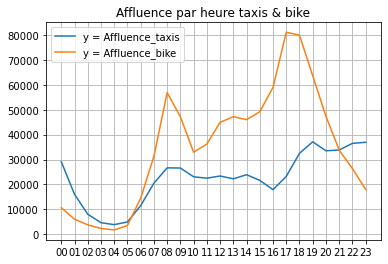

In [151]:

y1 = nbtaxis
y2 = nbbike
plt.plot(heure, y1, label='y = Affluence_taxis')
plt.plot(heure, y2, label='y = Affluence_bike')
plt.legend()
plt.title('Affluence par heure taxis & bike')
plt.grid(True)
plt.show()

In [ ]:
##groupDF4.select(groupDF4.columns[:1]).take(3)

In [ ]:
groupDF5.show(truncate=False)

In [ ]:
dechif=groupDF4.collect()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting utils

# plot bars with x items and y values
def plotBars(x, y, x_label,y_label,b_tittle):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x,y, color=['blue','green','red'])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(b_tittle)
    plt.show() 

    '''plt.bar(x,y, color=['firebrick', 'green', 'blue', 'black', 'red',
                    'purple', 'seagreen', 'skyblue', 'black', 'tomato'])
plt.xlabel('Categories')
plt.ylabel("Values")
plt.title('Barplot with colored bars')
plt.show()
'''
'''pyplot.figure(figsize = (8, 8))
x = [0.1, 0.2, 0.3, 0.1]
pyplot.pie(x, labels = ['A', 'B', 'C', 'D'])
pyplot.legend()'''

In [ ]:
stationNames = list(map(lambda pair : pair[0], dechif))
waitingTimes = list(map(lambda pair : pair[1], dechif))
x_label = 'gender'
y_label = 'Frequence'
b_tittle= 'frequence by user gender'
plotBars(stationNames,waitingTimes,x_label,y_label,b_tittle)

## Visualization analyses

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting utils

# plot bars with x items and y values
def plotBars(x, y):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x,y)
    plt.show() 

# set size for plots
plt.rcParams['figure.figsize'] = [15, 5]

# the composition of all the transformations
result = rddWordCount.flatMap(lambda line: line.split(' ')) \
                    .map(lambda word: (word, 1)) \
                    .reduceByKey(lambda a,b:a + b) \
                    .sortBy(lambda pair: pair[1], ascending=False)
# for x in result.collect():
   # print("Word: %s, Occurences: %s" % x)
wordCountRes = result.collect()
    
# lets plot the results of our analysis
stationNames = list(map(lambda pair : pair[0], wordCountRes))
waitingTimes = list(map(lambda pair : pair[1], wordCountRes))
plotBars(stationNames,waitingTimes)